# Face Detector and locater

### importing general Modules

In [1]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Getting the data

In [2]:
data=pd.read_csv('faces.csv')
data.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


#### Normalising the data

In [3]:

data['x0']=data['x0']/data['width']
data['x1']=data['x1']/data['width']
data['y0']=data['y0']/data['height']
data['y1']=data['y1']/data['height']

In [4]:
data.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,0.367592,0.160000,0.515379,0.332000
1,00001044.jpg,2000,1333,0.395500,0.089272,0.600000,0.327082
2,00001050.jpg,667,1000,0.455772,0.155000,0.610195,0.331000
3,00001736.jpg,626,417,0.234824,0.033573,0.829073,0.726619
4,00003121.jpg,626,418,0.738019,0.143541,0.956869,0.397129


#### GEtting to know the data

In [5]:
data.describe()

,width,height,x0,y0,x1,y1
count,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000
mean,967.967164,829.165373,0.378655,0.186899,0.634913,0.483463
std,651.959869,604.168252,0.175169,0.138616,0.176898,0.170959
min,150.000000,115.000000,0.000500,0.000167,0.113293,0.120235
25%,612.000000,433.000000,0.260000,0.082392,0.522609,0.352864
50%,800.000000,683.000000,0.378828,0.159264,0.635607,0.465602
75%,1200.000000,1024.000000,0.484763,0.262385,0.755000,0.593137
max,8192.000000,6680.000000,0.907813,0.791000,1.000000,1.000000


### Changing image name to path

In [6]:
#sample image path
#/images/00000003.jpg

data['image_name']='images/'+data['image_name']

In [7]:
data.head()

,image_name,width,height,x0,y0,x1,y1
0,images/00001722.jpg,1333,2000,0.367592,0.160000,0.515379,0.332000
1,images/00001044.jpg,2000,1333,0.395500,0.089272,0.600000,0.327082
2,images/00001050.jpg,667,1000,0.455772,0.155000,0.610195,0.331000
3,images/00001736.jpg,626,417,0.234824,0.033573,0.829073,0.726619
4,images/00003121.jpg,626,418,0.738019,0.143541,0.956869,0.397129


#### Reveiwing the data

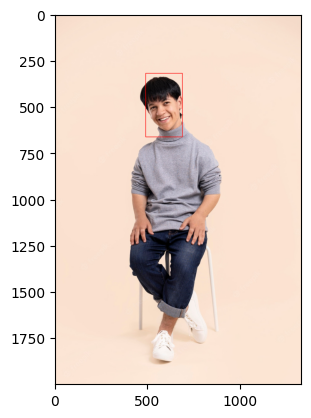

In [8]:
import cv2
import matplotlib.pyplot as plt
x1 = data.iloc[0][3]
x2 = data.iloc[0][5]
y1 = data.iloc[0][4]
y2 = data.iloc[0][6]
height = data.iloc[0]["height"]
width = data.iloc[0]["width"]

p1 = (int(x1*width),int(y1*height))
p2= (int(x2*width),int(y2*height))
img = cv2.imread("images/00001722.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
cv2.rectangle(img,p1,p2,color = (255, 0, 0) ,thickness = 2)
plt.imshow(img)

### PreProcessing the data
##### Image to array

In [9]:
#preprocessing data

import tensorflow as tf

def preprocessing(file_path,label,pred=False):
    """
        This function return the tensor of image and label
        pred=True mean it is for prediction 
    """
    img = tf.io.read_file(file_path)   #read the image
    img= tf.io.decode_jpeg(img, channels=3)  #convert image into tensor
    height_img = img.shape[0]
    width_img = img.shape[1]
    img  = tf.image.resize(img, [224,224])   #resize the image
    img  = tf.cast(img, tf.float32)/255.0    #Normalize the element of img tensor. Tf doesnot support auto type casting so use tf.cast to convert img into float32 before normalizing
    if pred:
        return img, width, height
    return img, label

#### Creating data to train

In [10]:
#creating dataset

def to_dataset(data):
    dataset=tf.data.Dataset.from_tensor_slices((data['image_name'],data.drop(columns=['image_name','width','height']))) #creates dataset from prev pandas data
    dataset=dataset.map(preprocessing) #applies fnc to each element
    dataset=dataset.batch(32)  #batches the dataset elements into batches of 32
    dataset=dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # allows data to be prefetched, improving performance by overlapping data
    return dataset
train_data=to_dataset(data)

#### Using pretrained model

In [11]:
# Transfer learning (using pretrained model Restnet50)
from tensorflow.keras.applications import ResNet50
re_model = tf.keras.applications.ResNet50(
    include_top=False,  # This is useful when you want to use the model for a different task
    weights='imagenet', #This loads the weights pre-trained on the ImageNet dataset.
    input_tensor=None,  #This is used when you want to provide your own input tensor
    input_shape=(224,224,3),
)
print(re_model.output_shape)

(None, 7, 7, 2048)


#### adding up our model

In [12]:
#creating our model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D,Flatten,Dense


model = Sequential()
model.add(re_model)
model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2), padding="valid")) # to reduce the spatial dimensions of the feature maps
model.add(Flatten())
model.add(Dense(250,activation="relu"))
model.add(Dense(250,activation="relu"))
model.add(Dense(4,activation="linear"))


In [13]:
model.compile(loss = tf.keras.losses.MeanSquaredError(), 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = [tf.keras.metrics.R2Score()]
             )

In [ ]:
model.fit(train_data,epochs=20)

### Predicting sample data

In [15]:
def preprocess_predict(img_path):
    img = tf.io.read_file(img_path)   #read the content of file
    img= tf.io.decode_jpeg(img, channels=3)  #convert image into tensor
    height_img = img.shape[0]
    width_img = img.shape[1]
    img  = tf.image.resize(img, [224,224])   #resize the image
    img  = tf.cast(img, tf.float32)/255.0    #Normalize the element of img tensor. Tf doesnot support auto type casting so use tf.cast to convert img into float32 berofe normalizing
    #predict
    img = tf.reshape(img,(1,224,224,3))
    pred = model.predict(img)
    imr = cv2.imread(img_path)
    x0 = int(pred[0][0] * width_img)
    y0 = int(pred[0][1] * height_img)
    x1 = int(pred[0][2] * width_img)
    y1 = int(pred[0][3] * height_img)
    p1 = (x0,y0)
    p2 = (x1,y1)
    color = (255,0,0)
    thickness = 5
    cv2.rectangle(imr,p1,p2,color,thickness)
    print(pred[0][0]*width,pred[0][1]*height)
    print(pred[0][2]*width,pred[0][3]*height)
    plt.imshow(imr)
    



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
350.39381033182144 271.43698930740356
883.5952087044716 1202.9249668121338


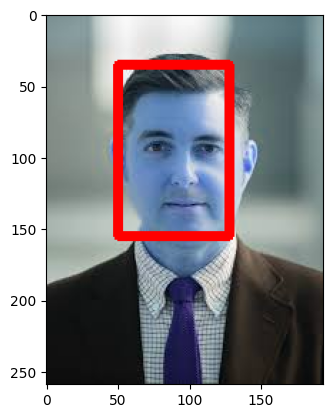

In [16]:
preprocess_predict('face1.jpg')